## 1. Setup and Configuration

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import joblib
import json
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Matplotlib settings
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# Define paths (adjust if running outside this directory)
BASE_DIR = Path.cwd().parent if 'notebooks' in str(Path.cwd()) else Path.cwd()
DATA_DIR = BASE_DIR / "data"
EXPORTED_DIR = DATA_DIR / "exported_data" / "per_asset"
PROCESSED_DIR = DATA_DIR / "processed"

OUTPUT_DIR = BASE_DIR / "models" / "xgboost"
RESULTS_DIR = BASE_DIR / "results" / "xgboost"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Base directory: {BASE_DIR}")
print(f"Data directory: {EXPORTED_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Results directory: {RESULTS_DIR}")
print(f"\nData directory exists: {EXPORTED_DIR.exists()}")

Base directory: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai
Data directory: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\data\exported_data\per_asset
Output directory: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\models\xgboost
Results directory: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\results\xgboost

Data directory exists: True


In [3]:
# Configuration
ASSETS = ["INTC", "AAPL", "NVDA", "IEF", "HYG", "BIL"]

XGBOOST_PARAMS = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.01,
    'max_depth': 5,
    'min_child_weight': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.1,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': 42,
    'n_estimators': 500
    # Note: early_stopping_rounds/eval_metric removed - not supported in XGBoost 3.x __init__
}

print("Configuration:")
print(f"Assets: {ASSETS}")
print(f"\nXGBoost Parameters:")
for k, v in XGBOOST_PARAMS.items():
    print(f"  {k}: {v}")

Configuration:
Assets: ['INTC', 'AAPL', 'NVDA', 'IEF', 'HYG', 'BIL']

XGBoost Parameters:
  objective: reg:squarederror
  learning_rate: 0.01
  max_depth: 5
  min_child_weight: 3
  subsample: 0.8
  colsample_bytree: 0.8
  gamma: 0.1
  reg_alpha: 0.1
  reg_lambda: 1.0
  random_state: 42
  n_estimators: 500


## 2. Verify Data Availability

In [4]:
# Check available assets
print("Checking data availability...\n")

for asset in ASSETS:
    asset_dir = EXPORTED_DIR / asset
    if asset_dir.exists():
        files = list(asset_dir.glob("*.csv"))
        print(f"✅ {asset}: {len(files)} CSV files found")
    else:
        print(f"❌ {asset}: Directory not found!")

Checking data availability...

✅ INTC: 6 CSV files found
✅ AAPL: 6 CSV files found
✅ NVDA: 6 CSV files found
✅ IEF: 6 CSV files found
✅ HYG: 6 CSV files found
✅ BIL: 6 CSV files found


## 3. Data Loading Functions

In [5]:
def load_asset_data(asset):
    """
    Load train/val/test data for a specific asset.
    
    Args:
        asset: Asset ticker (e.g., 'INTC')
    
    Returns:
        Dictionary with X_train, X_val, X_test, y_train, y_val, y_test
    """
    asset_dir = EXPORTED_DIR / asset
    
    X_train = pd.read_csv(asset_dir / "X_train.csv", index_col=0)
    X_val = pd.read_csv(asset_dir / "X_val.csv", index_col=0)
    X_test = pd.read_csv(asset_dir / "X_test.csv", index_col=0)
    
    y_train = pd.read_csv(asset_dir / "y_train.csv", index_col=0).squeeze()
    y_val = pd.read_csv(asset_dir / "y_val.csv", index_col=0).squeeze()
    y_test = pd.read_csv(asset_dir / "y_test.csv", index_col=0).squeeze()
    
    return {
        "X_train": X_train,
        "X_val": X_val,
        "X_test": X_test,
        "y_train": y_train,
        "y_val": y_val,
        "y_test": y_test
    }

# Test loading with first asset
first_asset = ASSETS[0]
test_data = load_asset_data(first_asset)
print(f"{first_asset} data loaded:")
print(f"  X_train: {test_data['X_train'].shape}")
print(f"  y_train: {test_data['y_train'].shape}")
print(f"  Features: {test_data['X_train'].shape[1]}")

INTC data loaded:
  X_train: (1706, 76)
  y_train: (1706,)
  Features: 76


## 4. Model Training Functions

In [6]:
def train_xgboost_model(data_dict, asset, params=XGBOOST_PARAMS):
    """
    Train XGBoost model with early stopping on validation set.
    
    Args:
        data_dict: Dictionary with train/val/test data
        asset: Asset name for logging
        params: XGBoost parameters
    
    Returns:
        Trained XGBoost model
    """
    print(f"\n{'='*60}")
    print(f"Training XGBoost model for {asset}")
    print(f"{'='*60}")
    
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    X_val = data_dict['X_val']
    y_val = data_dict['y_val']
    
    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    print(f"Features: {X_train.shape[1]}")
    
    # XGBoost 3.x: use callbacks for early stopping
    early_stop = xgb.callback.EarlyStopping(
        rounds=50,
        metric_name='rmse',
        data_name='validation_1',
        save_best=True
    )
    
    model = xgb.XGBRegressor(**params, callbacks=[early_stop])
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=50
    )
    
    print(f"\n✅ Training complete!")
    print(f"Best iteration: {model.best_iteration}")    
    print(f"Best score: {model.best_score:.6f}")
    
    return model

## 5. Evaluation Functions

In [7]:
def evaluate_model(model, data_dict, asset):
    """
    Evaluate model on train/val/test sets.
    
    Returns:
        Dictionary with metrics for each split
    """
    print(f"\n{'='*60}")
    print(f"Evaluating {asset} Model")
    print(f"{'='*60}")
    
    results = {}
    
    for split in ['train', 'val', 'test']:
        X = data_dict[f'X_{split}']
        y_true = data_dict[f'y_{split}']
        
        y_pred = model.predict(X)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        
        # Financial metrics
        directional_acc = np.mean(np.sign(y_true) == np.sign(y_pred))
        
        # Sharpe: Calculate returns from strategy (position * actual return)
        # Position = sign of prediction, return = actual return
        strategy_returns = np.sign(y_pred) * y_true
        sharpe_pred = strategy_returns.mean() / (strategy_returns.std() + 1e-8) * np.sqrt(252)
        
        results[split] = {
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'directional_accuracy': directional_acc,
            'sharpe_predictions': sharpe_pred,
            'y_true': y_true,
            'y_pred': y_pred
        }
        
        print(f"\n{split.upper()} Metrics:")
        print(f"  RMSE: {rmse:.6f}")
        print(f"  MAE: {mae:.6f}")
        print(f"  R²: {r2:.4f}")
        print(f"  Sharpe (predictions): {sharpe_pred:.4f}")    
        print(f"  Directional Accuracy: {directional_acc:.2%}")
    
    return results



## 6. Feature Importance Analysis

In [8]:
def analyze_feature_importance(model, feature_names, asset, top_n=20):
    """
    Analyze and visualize feature importance.
    
    Returns:
        DataFrame with feature importance scores
    """
    print(f"\nAnalyzing feature importance for {asset}...")
    
    # Get importance dict (may be empty for some features)
    importance_dict = model.get_booster().get_score(importance_type='gain')
    
    # Build full DataFrame safely
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': [importance_dict.get(f'f{i}', 0.0) for i in range(len(feature_names))]
    }).sort_values('importance', ascending=False)
    
    # Plot top features
    plt.figure(figsize=(10, 6))
    top_features = importance_df.head(top_n)
    plt.barh(top_features['feature'], top_features['importance'])
    plt.xlabel('Importance (Gain)')
    plt.ylabel('Feature')
    plt.title(f'Top {top_n} Features for {asset}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / f'{asset}_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Feature importance plot saved")
    
    return importance_df

## 7. Prediction Visualization

In [9]:
def visualize_predictions(results, asset):
    """
    Visualize predicted vs true returns on test set.
    """
    y_true = results['test']['y_true']
    y_pred = results['test']['y_pred']
    dates = y_true.index
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))
    
    # Time series plot
    axes[0].plot(dates, y_true, label='True Returns', alpha=0.7, linewidth=1)
    axes[0].plot(dates, y_pred, label='Predicted Returns', alpha=0.7, linewidth=1)
    axes[0].axhline(y=0, color='black', linestyle='--', alpha=0.3)
    axes[0].set_xlabel("Date")
    axes[0].set_ylabel("Return")
    axes[0].set_title(f"{asset} - Test Set Predictions vs True Returns")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Scatter plot
    axes[1].scatter(y_true, y_pred, alpha=0.5, s=20)
    axes[1].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 
                 'r--', label='Perfect Prediction')
    axes[1].set_xlabel("True Returns")
    axes[1].set_ylabel("Predicted Returns")
    axes[1].set_title(f"{asset} - Prediction Scatter Plot")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / f"{asset}_predictions.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Prediction plots saved")

## 8. Save Model Outputs

In [10]:
def save_model_outputs(model, results, importance_df, asset):
    """
    Save trained model, predictions, metadata, and feature importance.
    """
    print(f"\nSaving outputs for {asset}...")
    
    # Save model
    model_path = OUTPUT_DIR / f"{asset}_xgboost_model.joblib"
    joblib.dump(model, model_path)
    print(f"  ✅ Model saved: {model_path}")
    
    # Save predictions
    pred_df = pd.DataFrame({
        'date': results['test']['y_true'].index,
        'true_return': results['test']['y_true'].values,
        'predicted_return': results['test']['y_pred']
    })
    pred_path = OUTPUT_DIR / f"{asset}_predictions.csv"
    pred_df.to_csv(pred_path, index=False)
    print(f"  ✅ Predictions saved: {pred_path}")
    
    # Save metadata
    metadata = {
        'asset': asset,
        'training_date': datetime.now().isoformat(),
        'model_type': 'XGBoost',
        'n_features': len(importance_df),
        'best_iteration': int(model.best_iteration),
        'metrics': {
            'train_rmse': float(results['train']['rmse']),
            'val_rmse': float(results['val']['rmse']),
            'test_rmse': float(results['test']['rmse']),
            'test_mae': float(results['test']['mae']),
            'test_r2': float(results['test']['r2']),
            'test_directional_acc': float(results['test']['directional_accuracy']),
            'test_sharpe': float(results['test']['sharpe_predictions'])
        }
    }
    metadata_path = OUTPUT_DIR / f"{asset}_metadata.json"
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    print(f"  ✅ Metadata saved: {metadata_path}")
    
    # Save feature importance
    importance_path = OUTPUT_DIR / f"{asset}_feature_importance.csv"
    importance_df.to_csv(importance_path, index=False)
    print(f"  ✅ Feature importance saved: {importance_path}")

## 9. Main Training Loop

In [11]:
def train_all_assets():
    """
    Train XGBoost models for all assets and generate summary.
    """
    all_models = {}
    all_results = {}
    
    for asset in ASSETS:
        print(f"\n{'#'*60}")
        print(f"Processing asset: {asset}")
        print(f"{'#'*60}")
        
        try:
            # Load data
            data_dict = load_asset_data(asset)
            
            # Train model
            model = train_xgboost_model(data_dict, asset)
            all_models[asset] = model
            
            # Evaluate
            results = evaluate_model(model, data_dict, asset)
            all_results[asset] = results
            
            # Feature importance
            importance_df = analyze_feature_importance(
                model, data_dict['X_train'].columns.tolist(), asset
            )
            
            # Visualize predictions
            visualize_predictions(results, asset)
            
            # Save everything
            save_model_outputs(model, results, importance_df, asset)
            
            print(f"\n✅ {asset} completed successfully!")
            
        except Exception as e:
            print(f"\n❌ Error processing {asset}: {str(e)}")
            import traceback
            traceback.print_exc()
    
    return all_models, all_results


############################################################
Processing asset: INTC
############################################################

Training XGBoost model for INTC
Training samples: 1706
Validation samples: 756
Features: 76
[0]	validation_0-rmse:0.01316	validation_1-rmse:0.01813
[50]	validation_0-rmse:0.01316	validation_1-rmse:0.01813
[50]	validation_0-rmse:0.01316	validation_1-rmse:0.01813

✅ Training complete!
Best iteration: 1
Best score: 0.018134

Evaluating INTC Model

TRAIN Metrics:
  RMSE: 0.013164
  MAE: 0.009910
  R²: -0.0000
  Sharpe (predictions): 0.7726
  Directional Accuracy: 52.70%

VAL Metrics:
  RMSE: 0.018134
  MAE: 0.014193
  R²: -0.0001
  Sharpe (predictions): 0.4138
  Directional Accuracy: 51.72%

TEST Metrics:
  RMSE: 0.020184
  MAE: 0.016202
  R²: -0.0018
  Sharpe (predictions): -0.1707
  Directional Accuracy: 49.50%

Analyzing feature importance for INTC...

✅ Training complete!
Best iteration: 1
Best score: 0.018134

Evaluating INTC Model

TRAIN M

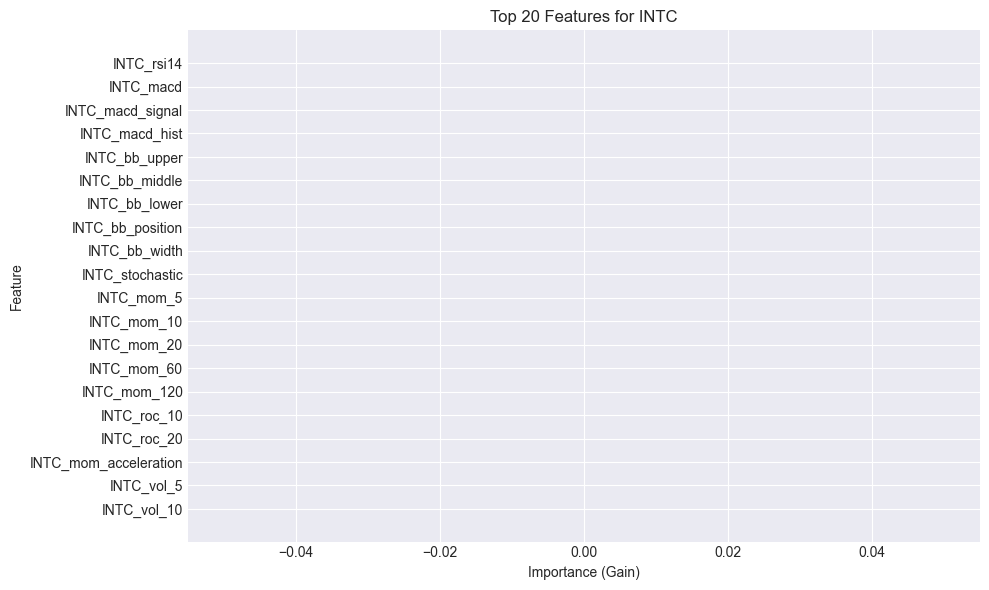

✅ Feature importance plot saved


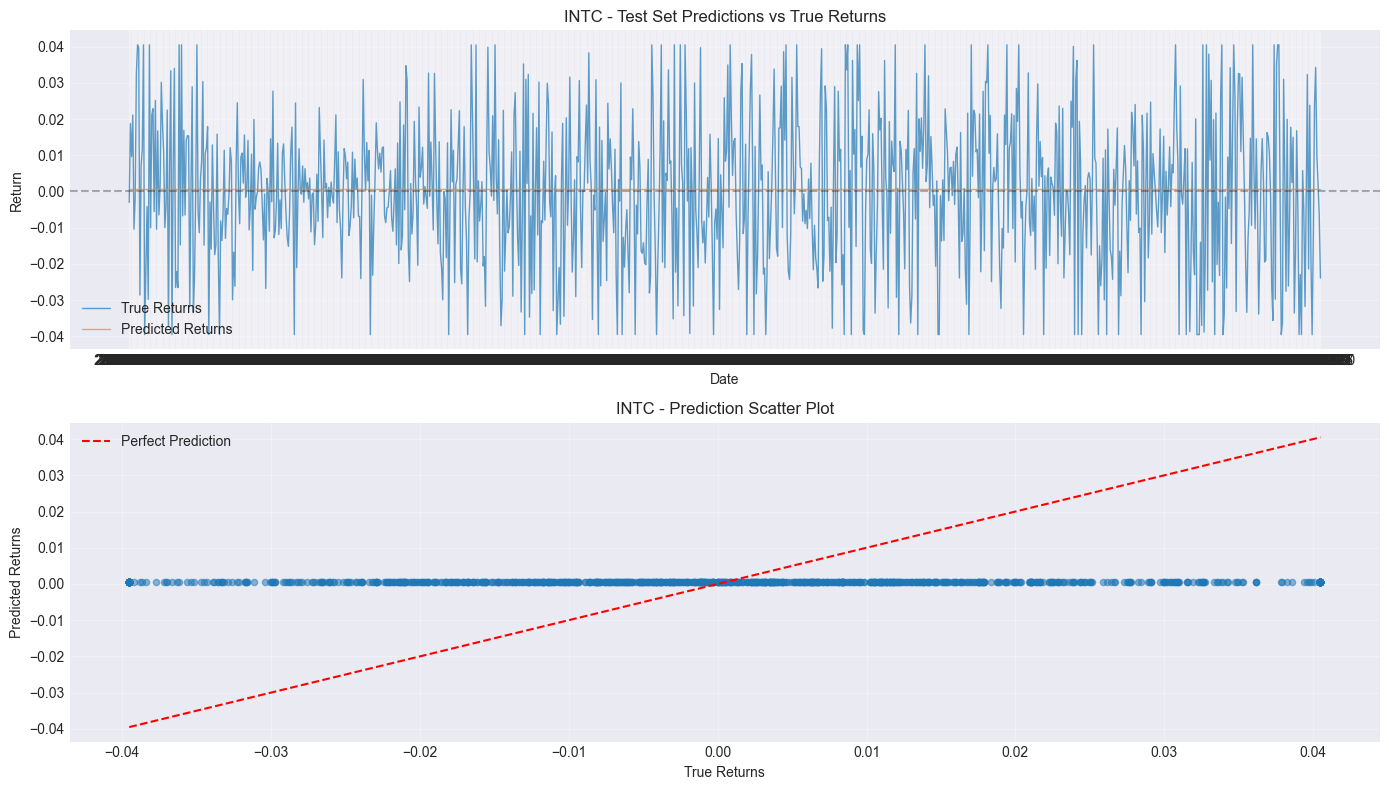

✅ Prediction plots saved

Saving outputs for INTC...
  ✅ Model saved: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\models\xgboost\INTC_xgboost_model.joblib
  ✅ Predictions saved: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\models\xgboost\INTC_predictions.csv
  ✅ Metadata saved: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\models\xgboost\INTC_metadata.json
  ✅ Feature importance saved: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\models\xgboost\INTC_feature_importance.csv

✅ INTC completed successfully!

############################################################
Processing asset: AAPL
############################################################

Training XGBoost model for AAPL
Training samples: 1706
Validation samples: 756
Features: 68
[0]	validation_0-rmse:0.01431	validation_1-rmse:0.01780
[50]	validation_0-rmse:0.01431	validation_1-rmse:0.01780
[50]	validation_0-rmse:0.01431	validation_1-rmse:0.01780
[100]	validation_0-rmse:0.01431	validation_1-rmse:

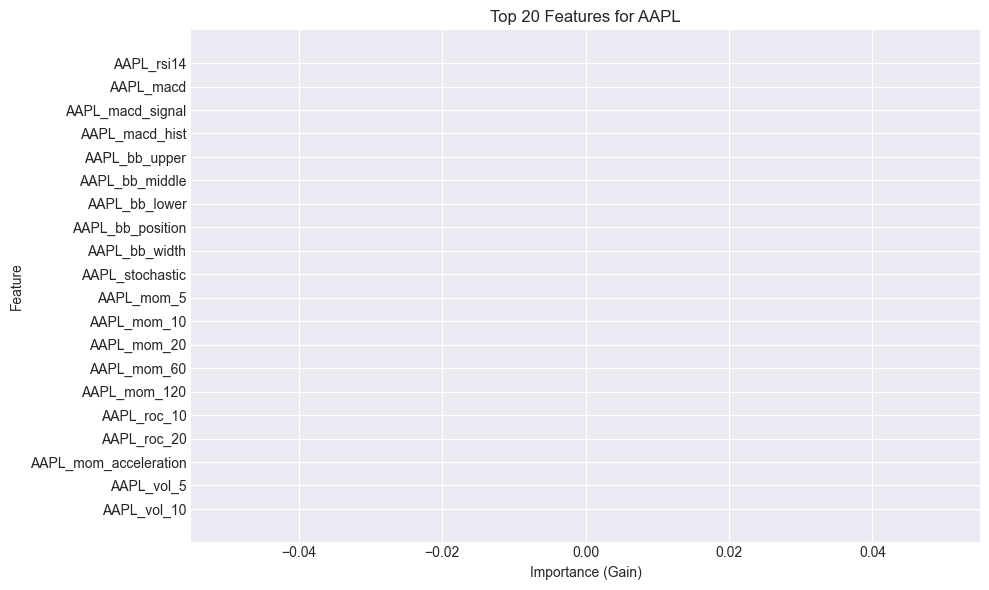

✅ Feature importance plot saved


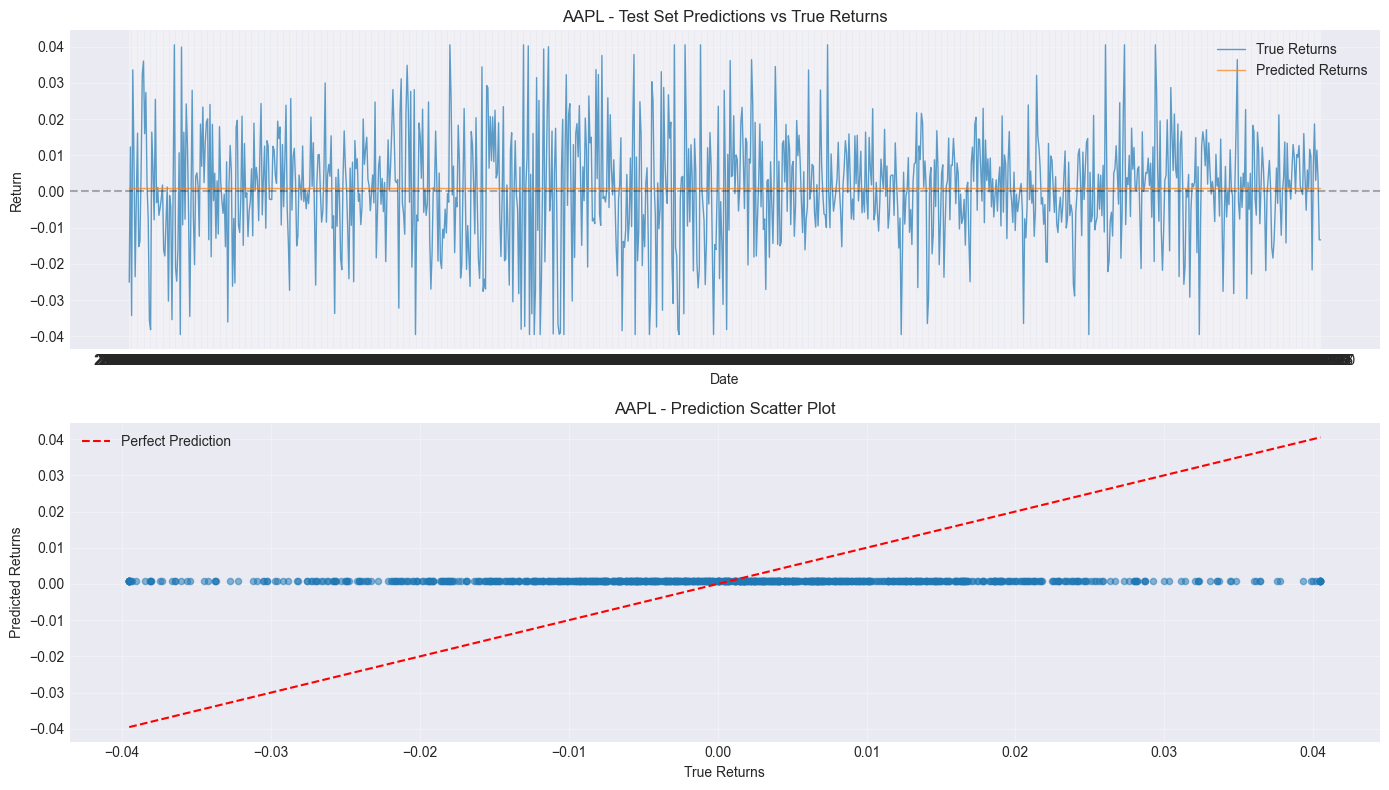

✅ Prediction plots saved

Saving outputs for AAPL...
  ✅ Model saved: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\models\xgboost\AAPL_xgboost_model.joblib
  ✅ Predictions saved: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\models\xgboost\AAPL_predictions.csv
  ✅ Metadata saved: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\models\xgboost\AAPL_metadata.json
  ✅ Feature importance saved: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\models\xgboost\AAPL_feature_importance.csv

✅ AAPL completed successfully!

############################################################
Processing asset: NVDA
############################################################

Training XGBoost model for NVDA
Training samples: 1706
Validation samples: 756
Features: 76
[0]	validation_0-rmse:0.01852	validation_1-rmse:0.02281
[50]	validation_0-rmse:0.01852	validation_1-rmse:0.02280
[50]	validation_0-rmse:0.01852	validation_1-rmse:0.02280
[100]	validation_0-rmse:0.01852	validation_1-rmse:

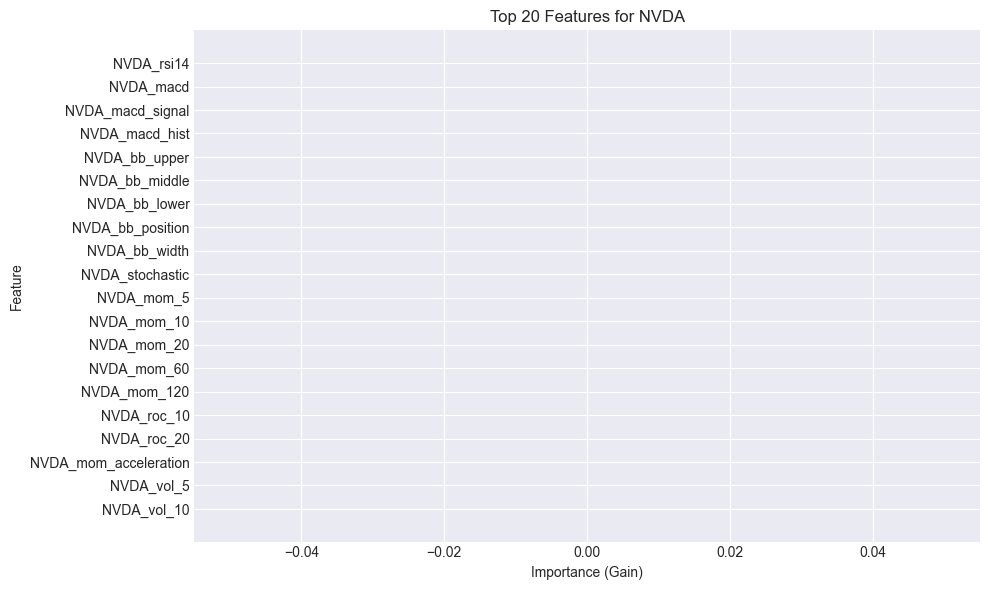

✅ Feature importance plot saved


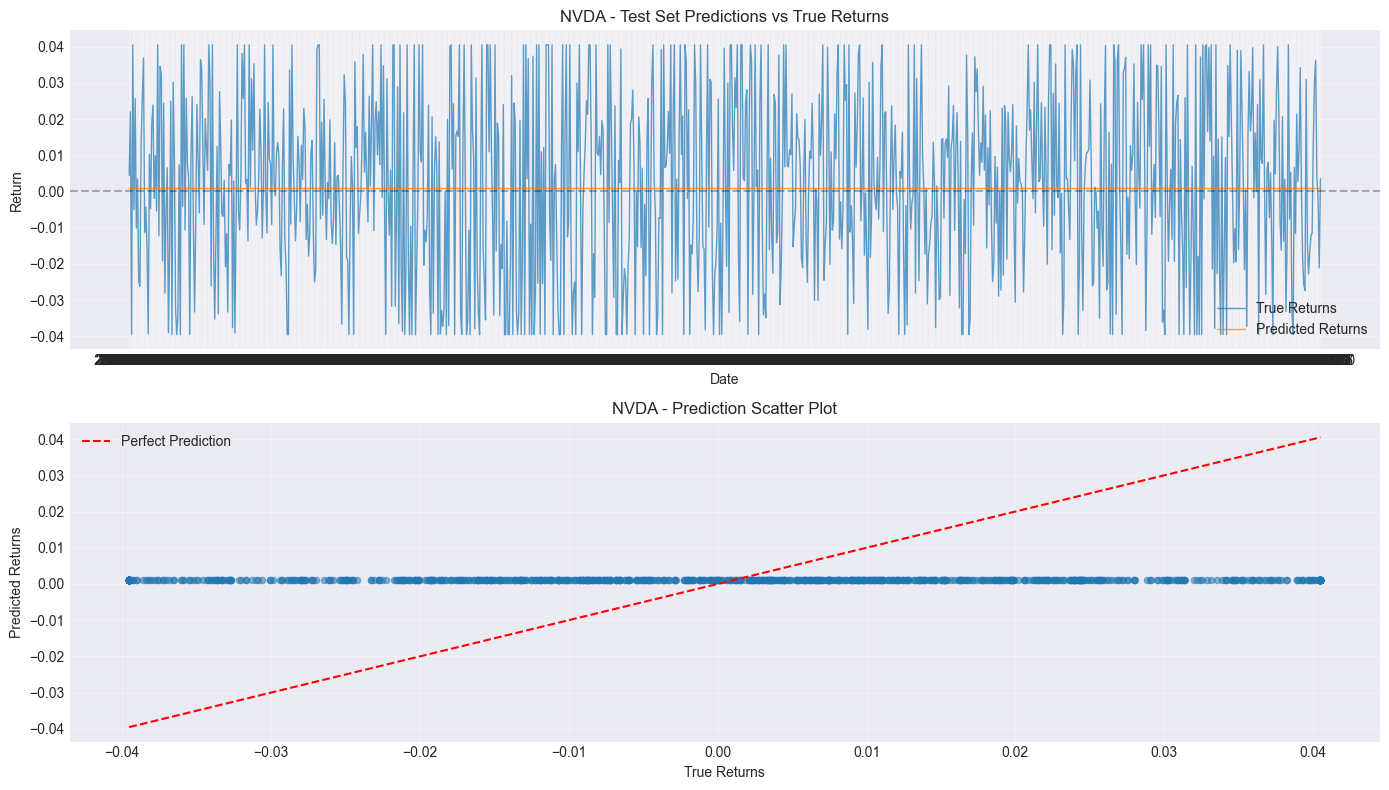

✅ Prediction plots saved

Saving outputs for NVDA...
  ✅ Model saved: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\models\xgboost\NVDA_xgboost_model.joblib
  ✅ Predictions saved: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\models\xgboost\NVDA_predictions.csv
  ✅ Metadata saved: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\models\xgboost\NVDA_metadata.json
  ✅ Feature importance saved: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\models\xgboost\NVDA_feature_importance.csv

✅ NVDA completed successfully!

############################################################
Processing asset: IEF
############################################################

Training XGBoost model for IEF
Training samples: 1706
Validation samples: 756
Features: 76
[0]	validation_0-rmse:0.00375	validation_1-rmse:0.00356
[50]	validation_0-rmse:0.00375	validation_1-rmse:0.00356
[50]	validation_0-rmse:0.00375	validation_1-rmse:0.00356
[96]	validation_0-rmse:0.00375	validation_1-rmse:0.0

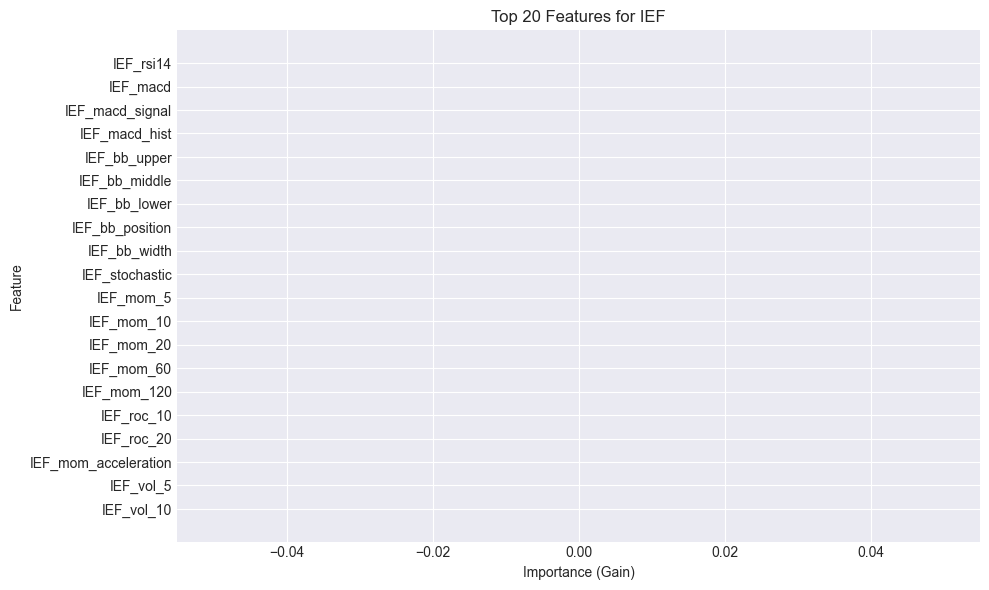

✅ Feature importance plot saved


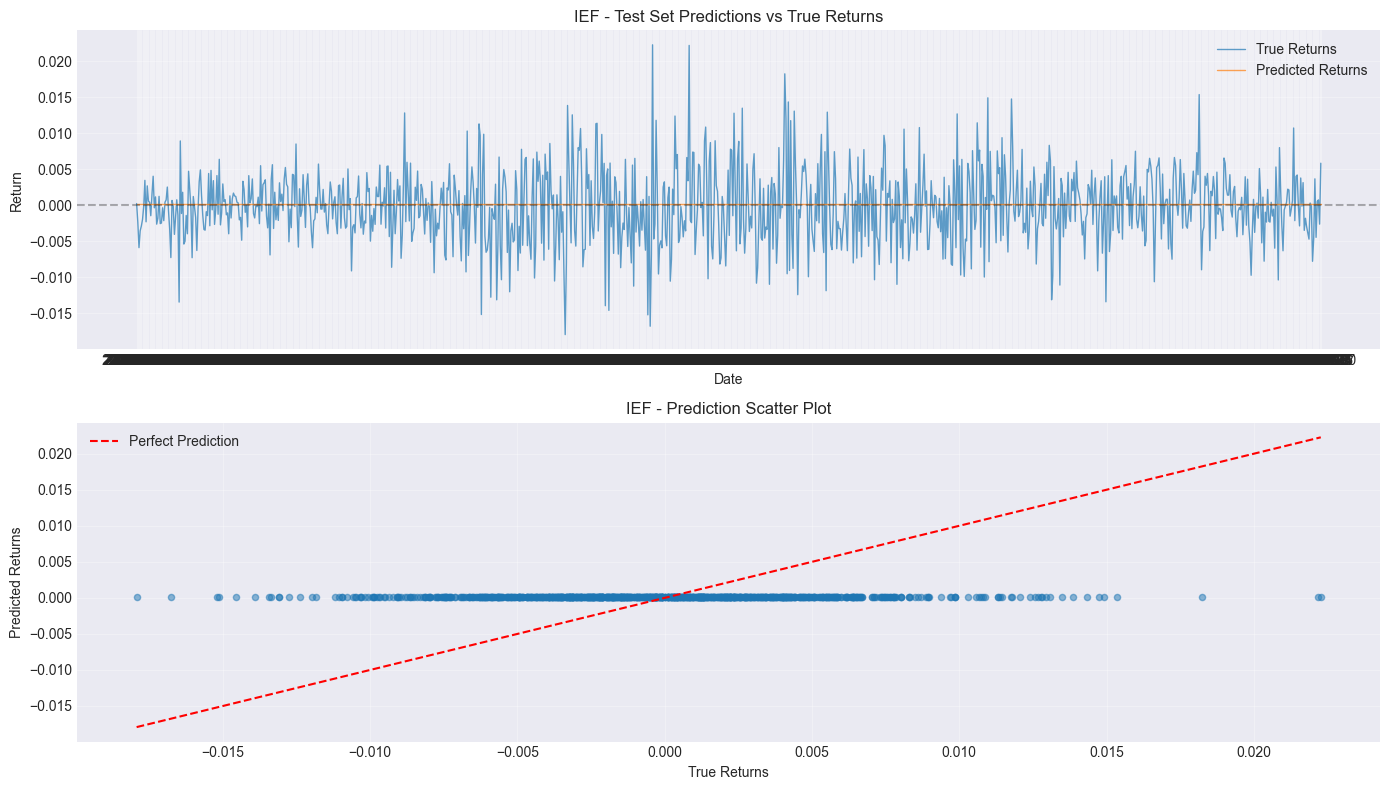

✅ Prediction plots saved

Saving outputs for IEF...
  ✅ Model saved: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\models\xgboost\IEF_xgboost_model.joblib
  ✅ Predictions saved: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\models\xgboost\IEF_predictions.csv
  ✅ Metadata saved: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\models\xgboost\IEF_metadata.json
  ✅ Feature importance saved: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\models\xgboost\IEF_feature_importance.csv

✅ IEF completed successfully!

############################################################
Processing asset: HYG
############################################################

Training XGBoost model for HYG
Training samples: 1706
Validation samples: 756
Features: 76
[0]	validation_0-rmse:0.00469	validation_1-rmse:0.00623
[0]	validation_0-rmse:0.00469	validation_1-rmse:0.00623
[50]	validation_0-rmse:0.00469	validation_1-rmse:0.00623
[50]	validation_0-rmse:0.00469	validation_1-rmse:0.00623
[6

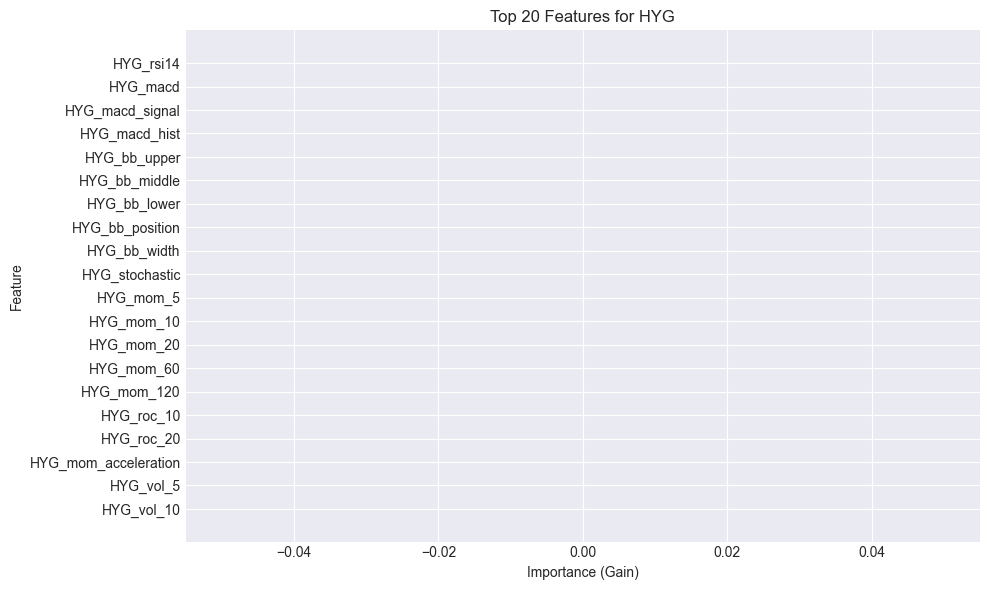

✅ Feature importance plot saved


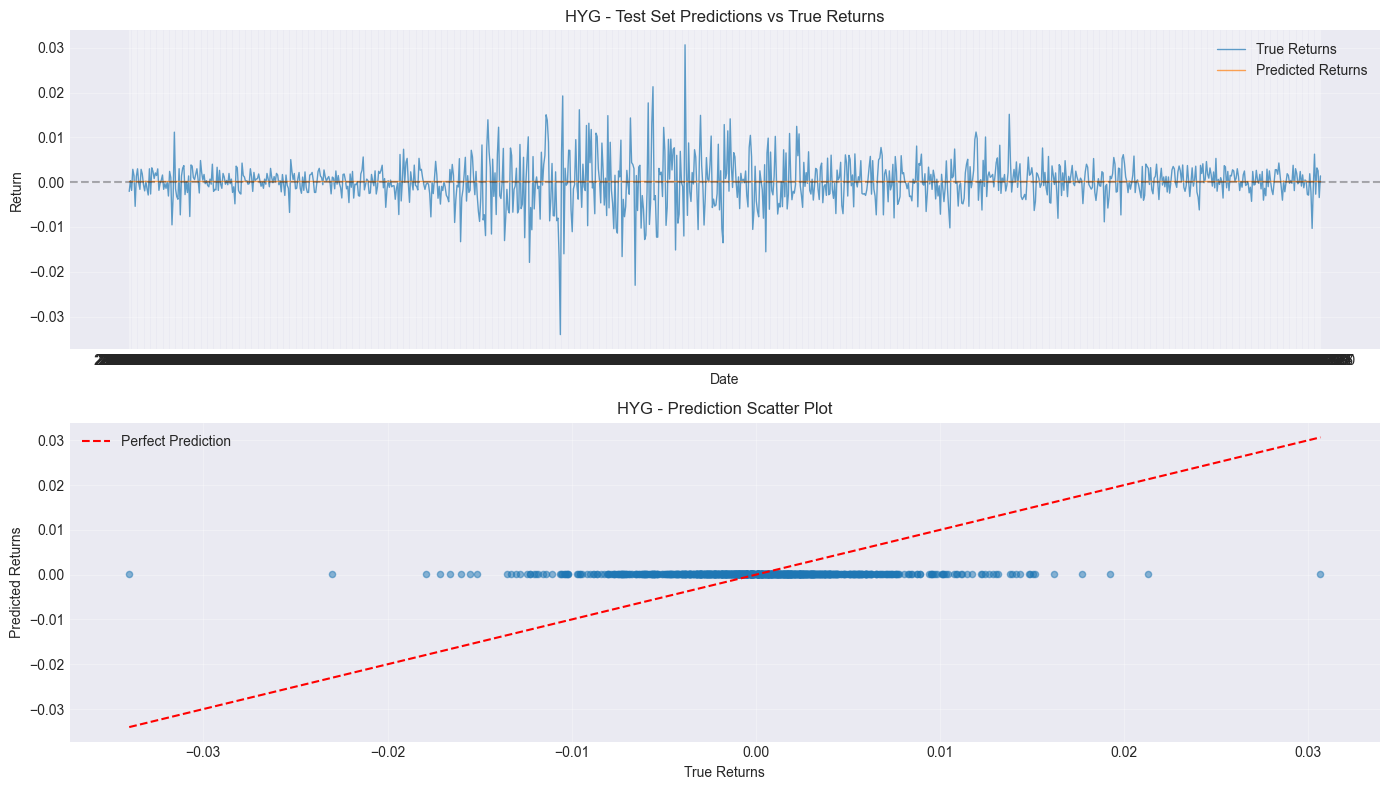

✅ Prediction plots saved

Saving outputs for HYG...
  ✅ Model saved: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\models\xgboost\HYG_xgboost_model.joblib
  ✅ Predictions saved: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\models\xgboost\HYG_predictions.csv
  ✅ Metadata saved: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\models\xgboost\HYG_metadata.json
  ✅ Feature importance saved: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\models\xgboost\HYG_feature_importance.csv

✅ HYG completed successfully!

############################################################
Processing asset: BIL
############################################################

Training XGBoost model for BIL
Training samples: 1706
Validation samples: 756
Features: 76
[0]	validation_0-rmse:0.00017	validation_1-rmse:0.00013

Training XGBoost model for BIL
Training samples: 1706
Validation samples: 756
Features: 76
[0]	validation_0-rmse:0.00017	validation_1-rmse:0.00013
[49]	validation_0-rmse:0

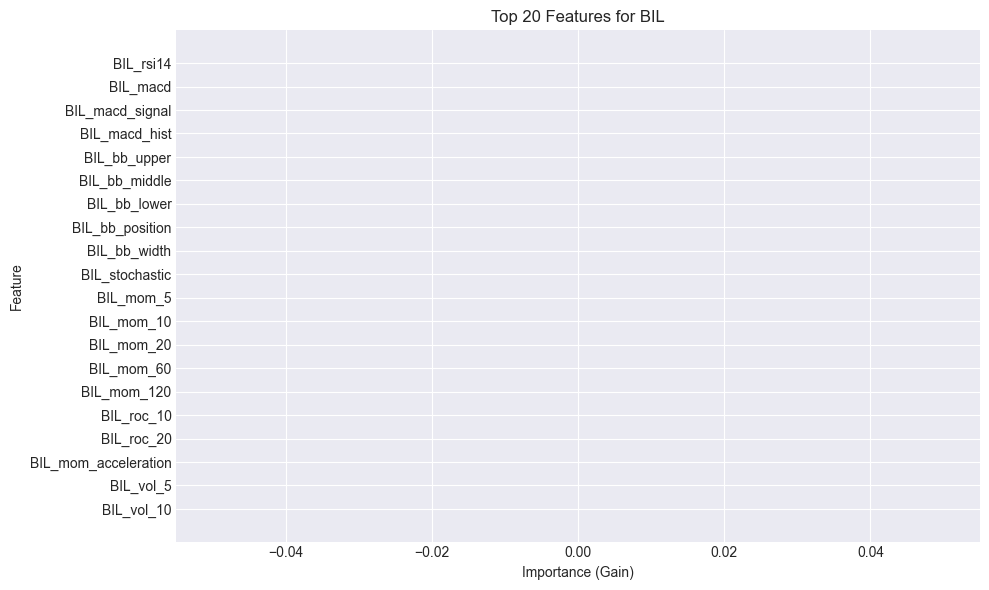

✅ Feature importance plot saved


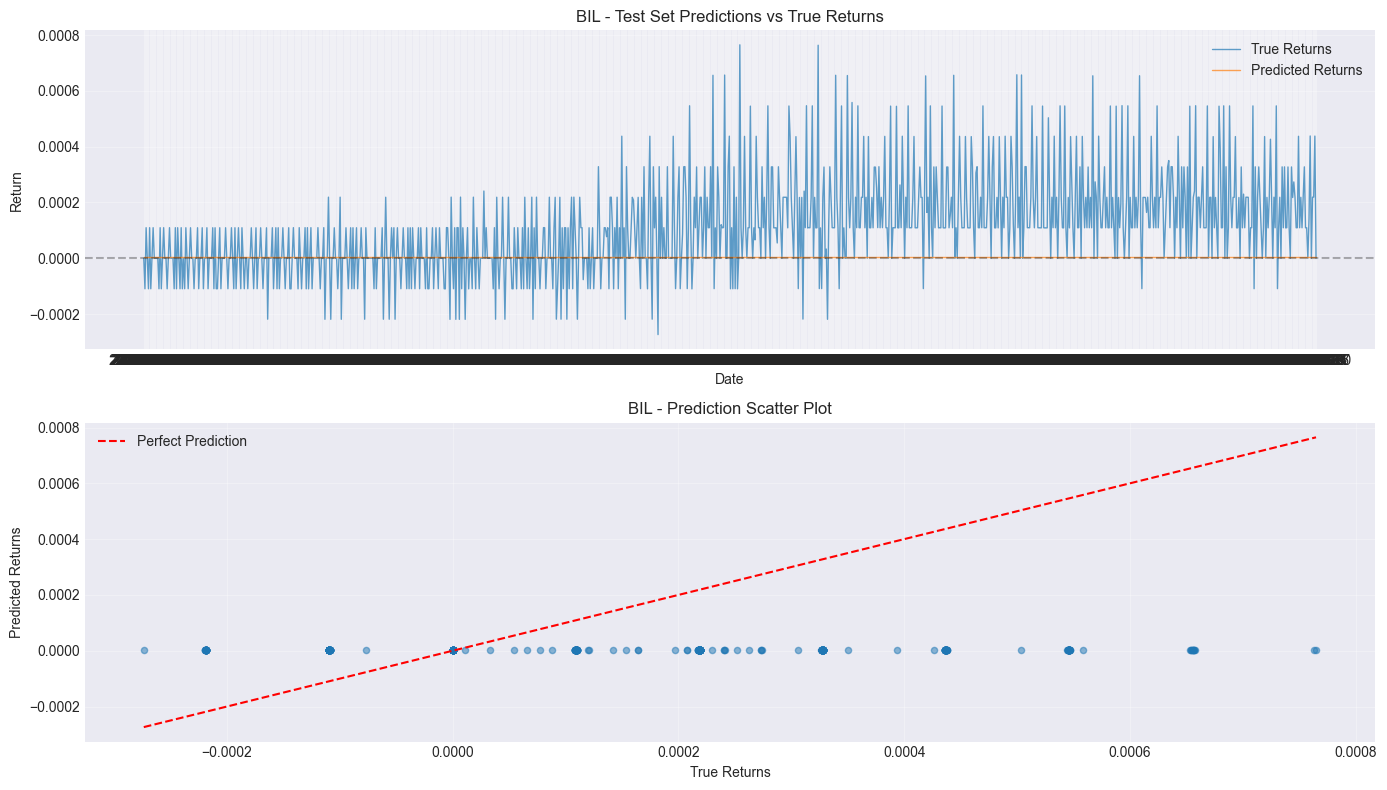

✅ Prediction plots saved

Saving outputs for BIL...
  ✅ Model saved: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\models\xgboost\BIL_xgboost_model.joblib
  ✅ Predictions saved: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\models\xgboost\BIL_predictions.csv
  ✅ Metadata saved: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\models\xgboost\BIL_metadata.json
  ✅ Feature importance saved: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\models\xgboost\BIL_feature_importance.csv

✅ BIL completed successfully!


In [12]:
# Execute training
all_models, all_results = train_all_assets()

## 10. Generate Summary Report

In [13]:
# Create summary DataFrame
summary_df = pd.DataFrame({
    asset: {
        'Test RMSE': all_results[asset]['test']['rmse'],
        'Test MAE': all_results[asset]['test']['mae'],
        'Test R²': all_results[asset]['test']['r2'],
        'Test Dir Acc': all_results[asset]['test']['directional_accuracy'],
        'Test Sharpe': all_results[asset]['test']['sharpe_predictions']
    } for asset in ASSETS if asset in all_results
}).T

print("\n" + "="*80)
print("SUMMARY METRICS - ALL ASSETS")
print("="*80)
print(summary_df.to_string())
print("="*80)

# Save summary
summary_path = RESULTS_DIR / "summary_metrics.csv"
summary_df.to_csv(summary_path)
print(f"\n✅ Summary saved: {summary_path}")

# Save all models
all_models_path = OUTPUT_DIR / "all_models.joblib"
joblib.dump(all_models, all_models_path)
print(f"✅ All models saved: {all_models_path}")


SUMMARY METRICS - ALL ASSETS
      Test RMSE  Test MAE   Test R²  Test Dir Acc  Test Sharpe
INTC   0.020184  0.016202 -0.001816      0.495020    -0.170672
AAPL   0.015791  0.012119 -0.000239      0.531873     0.604485
NVDA   0.024918  0.020997 -0.000941      0.536853     1.171406
IEF    0.005139  0.003989 -0.003743      0.478088    -0.514248
HYG    0.005010  0.003493 -0.000353      0.506972     0.336085
BIL    0.000204  0.000145 -0.392711      0.594622    10.196587

✅ Summary saved: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\results\xgboost\summary_metrics.csv
✅ All models saved: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\models\xgboost\all_models.joblib


## 11. Summary Visualizations

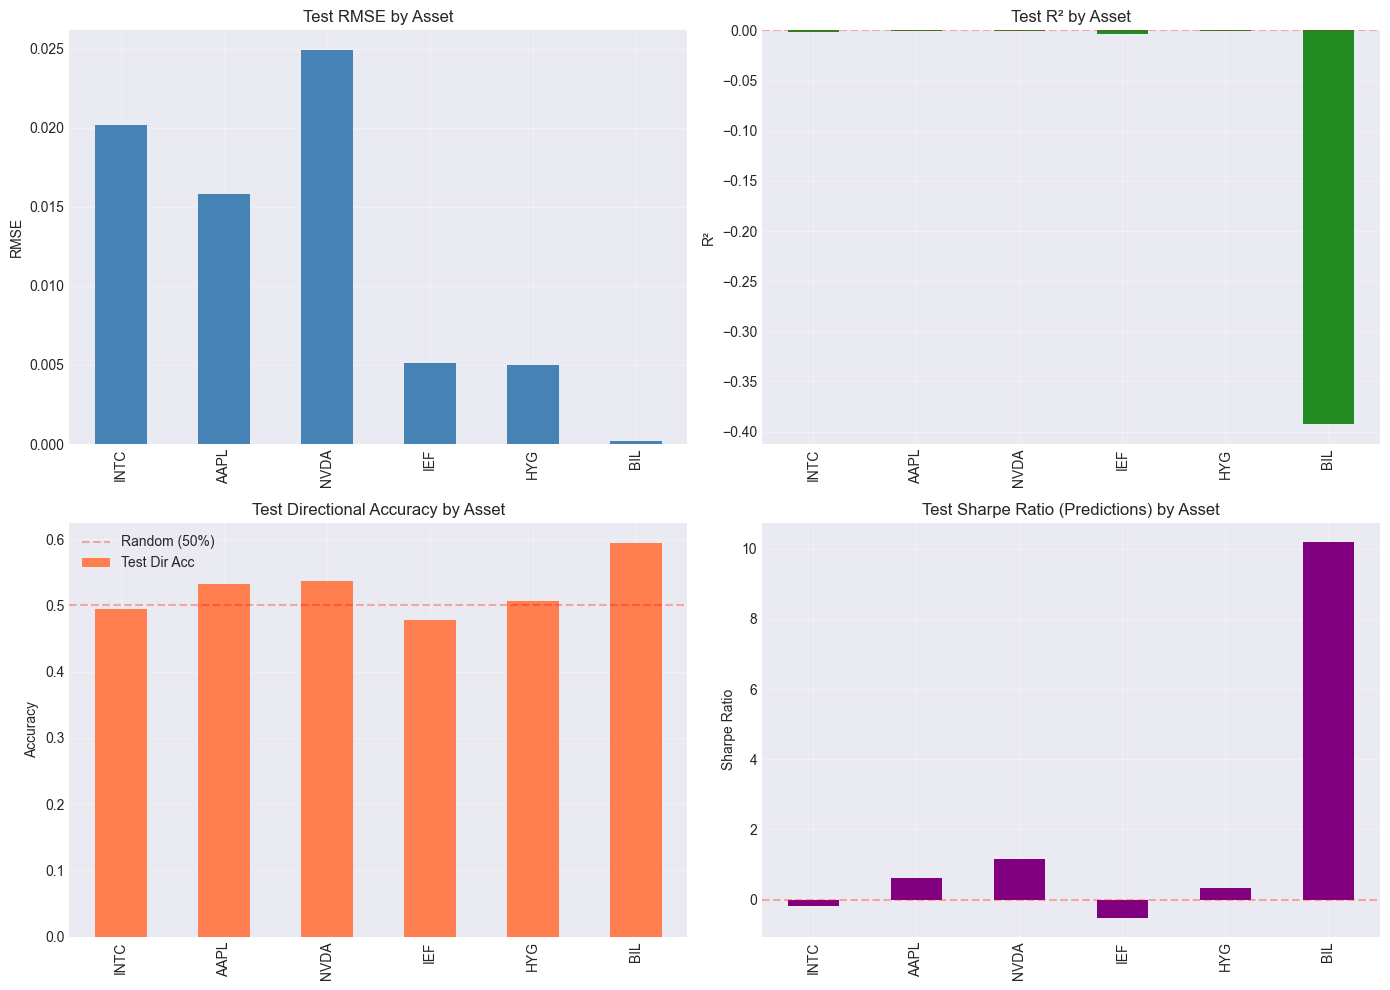

✅ Summary comparison plot saved


In [14]:
# Plot summary comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# RMSE comparison
summary_df['Test RMSE'].plot(kind='bar', ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title('Test RMSE by Asset')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].grid(True, alpha=0.3)

# R² comparison
summary_df['Test R²'].plot(kind='bar', ax=axes[0, 1], color='forestgreen')
axes[0, 1].set_title('Test R² by Asset')
axes[0, 1].set_ylabel('R²')
axes[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.3)
axes[0, 1].grid(True, alpha=0.3)

# Directional Accuracy
summary_df['Test Dir Acc'].plot(kind='bar', ax=axes[1, 0], color='coral')
axes[1, 0].set_title('Test Directional Accuracy by Asset')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].axhline(y=0.5, color='red', linestyle='--', alpha=0.3, label='Random (50%)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Sharpe Ratio
summary_df['Test Sharpe'].plot(kind='bar', ax=axes[1, 1], color='purple')
axes[1, 1].set_title('Test Sharpe Ratio (Predictions) by Asset')
axes[1, 1].set_ylabel('Sharpe Ratio')
axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.3)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / "summary_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print("✅ Summary comparison plot saved")

## 12. Final Report

In [15]:
print("\n" + "="*80)
print("TRAINING COMPLETE!")
print("="*80)
print(f"\n📁 Output Locations:")
print(f"  Models: {OUTPUT_DIR}")
print(f"  Results: {RESULTS_DIR}")
print(f"\n📊 Files Generated:")
print(f"  - {len(ASSETS)} trained models (.joblib)")
print(f"  - {len(ASSETS)} prediction files (.csv)")
print(f"  - {len(ASSETS)} metadata files (.json)")
print(f"  - {len(ASSETS)} feature importance files (.csv)")
print(f"  - {len(ASSETS)} prediction plots (.png)")
print(f"  - {len(ASSETS)} feature importance plots (.png)")
print(f"  - 1 summary metrics file (.csv)")
print(f"  - 1 summary comparison plot (.png)")
print(f"  - 1 all models file (.joblib)")
print(f"\n✅ Ready for ensemble modeling and production deployment!")
print("="*80)


TRAINING COMPLETE!

📁 Output Locations:
  Models: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\models\xgboost
  Results: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\results\xgboost

📊 Files Generated:
  - 6 trained models (.joblib)
  - 6 prediction files (.csv)
  - 6 metadata files (.json)
  - 6 feature importance files (.csv)
  - 6 prediction plots (.png)
  - 6 feature importance plots (.png)
  - 1 summary metrics file (.csv)
  - 1 summary comparison plot (.png)
  - 1 all models file (.joblib)

✅ Ready for ensemble modeling and production deployment!
